**ЗАВДАННЯ 1.** Машинний переклад на базі трансформерів.

In [9]:
# Встановлення бібліотек
!pip install transformers datasets sacrebleu evaluate sentencepiece accelerate -q

import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    MarianMTModel,
    MarianTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    pipeline
)
import evaluate
import numpy as np
import random


import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from diffusers import StableDiffusionPipeline

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [13]:
# Підготовка та розподіл даних
model_checkpoint = "Helsinki-NLP/opus-mt-en-uk"
tokenizer = MarianTokenizer.from_pretrained(model_checkpoint)

def prepare_data(file_path, num_samples=12000):
    # Читаємо весь файл
    df = pd.read_csv(file_path, sep='\t', header=None, names=['en', 'uk', 'meta'])
    df = df[['en', 'uk']]

    # Перемішуємо дані
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Беремо частину для навчання та частину для тесту
    train_df = df.iloc[:num_samples]
    test_df = df.iloc[num_samples : num_samples + 500]

    return train_df, test_df

try:
    train_df, test_df = prepare_data('ukr.txt', num_samples=8000)

    # Створюємо Hugging Face Dataset
    train_dataset = Dataset.from_pandas(train_df)
    eval_dataset = Dataset.from_pandas(test_df.sample(200))

    print("Готово")

except FileNotFoundError:

    print(" Файл не знайдено!")

def preprocess_function(examples):
    model_inputs = tokenizer(examples["en"], max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["uk"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Токенізуємо лише навчальні та валідаційні дані
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Готово


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [14]:
# Налаштуванння тренування
model = MarianMTModel.from_pretrained(model_checkpoint)

args = Seq2SeqTrainingArguments(
    "finetuned-marian-en-uk",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    report_to="none",
    save_strategy="no"
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    tokenizer=tokenizer
)

print("\nПочинаємо навчання")
trainer.train()

/tmp/ipython-input-1534149979.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.



Починаємо навчання


Epoch,Training Loss,Validation Loss
1,No log,0.474291


TrainOutput(global_step=250, training_loss=0.5867643432617188, metrics={'train_runtime': 18.7148, 'train_samples_per_second': 427.468, 'train_steps_per_second': 13.358, 'total_flos': 31093275230208.0, 'train_loss': 0.5867643432617188, 'epoch': 1.0})

In [16]:
# Перевірка
def translate(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs)
    return tokenizer.decode(output[0], skip_special_tokens=True)

print("ПЕРЕВІРКА НА СКЛАДНИХ РЕЧЕННЯХ")

# Фільтруємо test_df, щоб знайти речення довжиною понад 8 слів
complex_tests = test_df[test_df['en'].str.split().str.len() > 8].sample(10)

for _, row in complex_tests.iterrows():
    en_part = row['en']
    true_uk_part = row['uk']

    predicted = translate(en_part)

    print(f"EN: {en_part}")
    print(f"Model: {predicted}")
    print(f"Real:  {true_uk_part}")
    print("-")

ПЕРЕВІРКА НА СКЛАДНИХ РЕЧЕННЯХ
EN: Tom wants to stay at home and watch TV.
Model: Том хоче залишитися вдома та подивитися телевізор.
Real:  Том хоче лишитися вдома і дивитися телевізор.
-
EN: I think it's unlikely that Tom will come to the party alone.
Model: Мені здається, малоймовірно, що Том прийде на вечірку один.
Real:  Гадаю, малоймовірно, що Том прийде на вечірку один.
-
EN: History is nothing like what you read in history books.
Model: Історія зовсім не схожа на те, що ви читаєте в історичних книжках.
Real:  Історія не має нічого спільного з тим, що ви читаєте в книгах по історії.
-
EN: Tom told Mary that he thought John had been arrested.
Model: Том сказав Мері, що, на його думку, Джона заарештували.
Real:  Том сказав Мері, що він гадає, що Джона заарештували.
-
EN: Although the arguments were rational, he was not convinced.
Model: Хоча аргументи були раціональними, він не був переконаний.
Real:  Хоча доводи були раціональними, його не переконали.
-
EN: All we can do is wait f

**ЗАВДАННЯ 2.** Генерація зображень. DCGAN і Fashion MNIST

In [27]:
# Налаштування пристрою
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(f"Використовується пристрій: {device}")

# Параметри
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 1
LATENT_DIM = 100
EPOCHS = 10
LR = 0.0002
BETA1 = 0.5

Використовується пристрій: cuda:0


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.6MB/s]


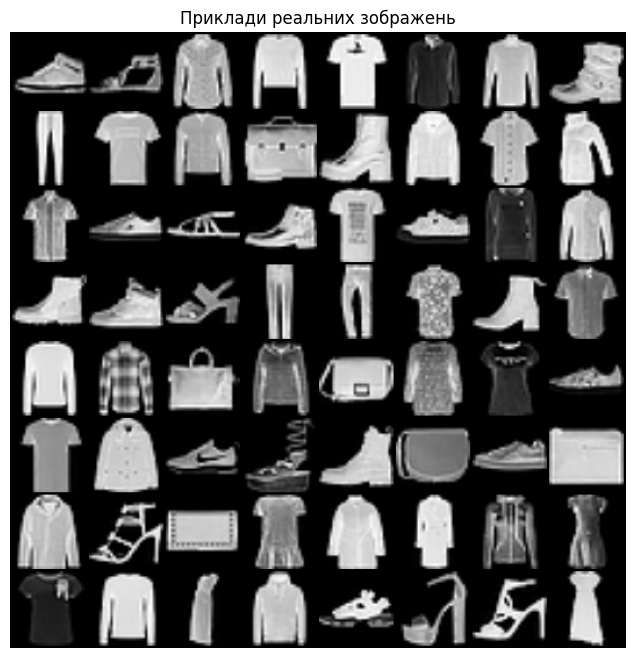

In [20]:
# Підготовка даних
# Ресайз, перетворення в тензор, нормалізація до [-1, 1]
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Завантаження датасету FashionMNIST
dataset = dset.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Перевірка даних
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Приклади реальних зображень")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [24]:
# Архітектура моделі


# Генерація зображень
class ImageSynthesizer(nn.Module):
    def __init__(self):
        super(ImageSynthesizer, self).__init__()

        self.pipeline = nn.Sequential(
            # Вхід: шумовий вектор LATENT_DIM

            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 32 x 32

            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
            # CHANNELS x 64 x 64
        )

    def forward(self, noise):
        return self.pipeline(noise)

    def infer(self, noise):  # для семантики / читабельності
        return self.forward(noise)

# Перевірка real / fake
class ImageInspector(nn.Module):
    def __init__(self):
        super(ImageInspector, self).__init__()

        self.pipeline = nn.Sequential(
            # Вхід: CHANNELS x 64 x 64

            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.pipeline(image)

    def infer(self, image):
        return self.forward(image)


# Ініціалізація моделей
def init_conv_weights(module):
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

# Створення моделей
synth_net = ImageSynthesizer().to(device)
synth_net.apply(init_conv_weights)

inspect_net = ImageInspector().to(device)
inspect_net.apply(init_conv_weights)

print(synth_net)
print(inspect_net)




ImageSynthesizer(
  (pipeline): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ta

In [25]:
# Налаштування навчання

adversarial_loss = nn.BCELoss()

# Фіксований шум для моніторингу прогресу генератора
probe_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

# Мітки
REAL_TAG = 1.
FAKE_TAG = 0.

# Оптимізатори
inspect_optimizer = optim.Adam(
    inspect_net.parameters(), lr=LR, betas=(BETA1, 0.999)
)

synth_optimizer = optim.Adam(
    synth_net.parameters(), lr=LR, betas=(BETA1, 0.999)
)

In [28]:
# Цикл навчання
generated_images = []
synth_losses = []
inspect_losses = []

print("Запуск навчання моделі")

for epoch in range(EPOCHS):
    for step, batch in enumerate(dataloader):


        # Навчання Інспектора

        inspect_net.zero_grad()

        # справжні зображення
        real_images = batch[0].to(device)
        batch_size = real_images.size(0)

        labels = torch.full(
            (batch_size,), REAL_TAG, device=device
        )

        real_output = inspect_net(real_images).view(-1)
        loss_real = adversarial_loss(real_output, labels)
        loss_real.backward()
        real_score = real_output.mean().item()

        # згенеровані зображення
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_images = synth_net(noise)

        labels.fill_(FAKE_TAG)
        fake_output = inspect_net(fake_images.detach()).view(-1)
        loss_fake = adversarial_loss(fake_output, labels)
        loss_fake.backward()
        fake_score_before = fake_output.mean().item()

        # оптимізація
        inspect_loss = loss_real + loss_fake
        inspect_optimizer.step()


        # Навчання синтезатора

        synth_net.zero_grad()

        labels.fill_(REAL_TAG)  # генератор хоче обдурити інспектора
        synth_output = inspect_net(fake_images).view(-1)

        synth_loss = adversarial_loss(synth_output, labels)
        synth_loss.backward()
        fake_score_after = synth_output.mean().item()

        synth_optimizer.step()

        # Логування
        if step % 50 == 0:
            print(
                f"[{epoch}/{EPOCHS}][{step}/{len(dataloader)}] "
                f"Inspector Loss: {inspect_loss:.4f} | "
                f"Synthesizer Loss: {synth_loss:.4f} | "
                f"D(real): {real_score:.4f} | "
                f"D(fake): {fake_score_before:.4f} → {fake_score_after:.4f}"
            )

        synth_losses.append(synth_loss.item())
        inspect_losses.append(inspect_loss.item())

    # Збереження прикладів після кожної епохи
    with torch.no_grad():
        preview = synth_net(probe_noise).detach().cpu()

    generated_images.append(
        vutils.make_grid(preview, padding=2, normalize=True)
    )

    print(f"Епоха {epoch} завершена")

Запуск навчання моделі
[0/10][0/469] Inspector Loss: 0.1969 | Synthesizer Loss: 4.1122 | D(real): 0.9282 | D(fake): 0.1049 → 0.0237
[0/10][50/469] Inspector Loss: 0.1476 | Synthesizer Loss: 3.0270 | D(real): 0.8888 | D(fake): 0.0234 → 0.0688
[0/10][100/469] Inspector Loss: 0.4709 | Synthesizer Loss: 2.4589 | D(real): 0.7214 | D(fake): 0.0757 → 0.1230
[0/10][150/469] Inspector Loss: 0.3757 | Synthesizer Loss: 1.6998 | D(real): 0.7281 | D(fake): 0.0203 → 0.2277
[0/10][200/469] Inspector Loss: 0.1936 | Synthesizer Loss: 3.6344 | D(real): 0.9257 | D(fake): 0.1021 → 0.0344
[0/10][250/469] Inspector Loss: 0.1451 | Synthesizer Loss: 3.3826 | D(real): 0.8830 | D(fake): 0.0097 → 0.0477
[0/10][300/469] Inspector Loss: 0.3295 | Synthesizer Loss: 3.3053 | D(real): 0.7805 | D(fake): 0.0467 → 0.0538
[0/10][350/469] Inspector Loss: 0.1426 | Synthesizer Loss: 3.3643 | D(real): 0.9212 | D(fake): 0.0547 → 0.0438
[0/10][400/469] Inspector Loss: 0.5601 | Synthesizer Loss: 3.2684 | D(real): 0.8401 | D(fake

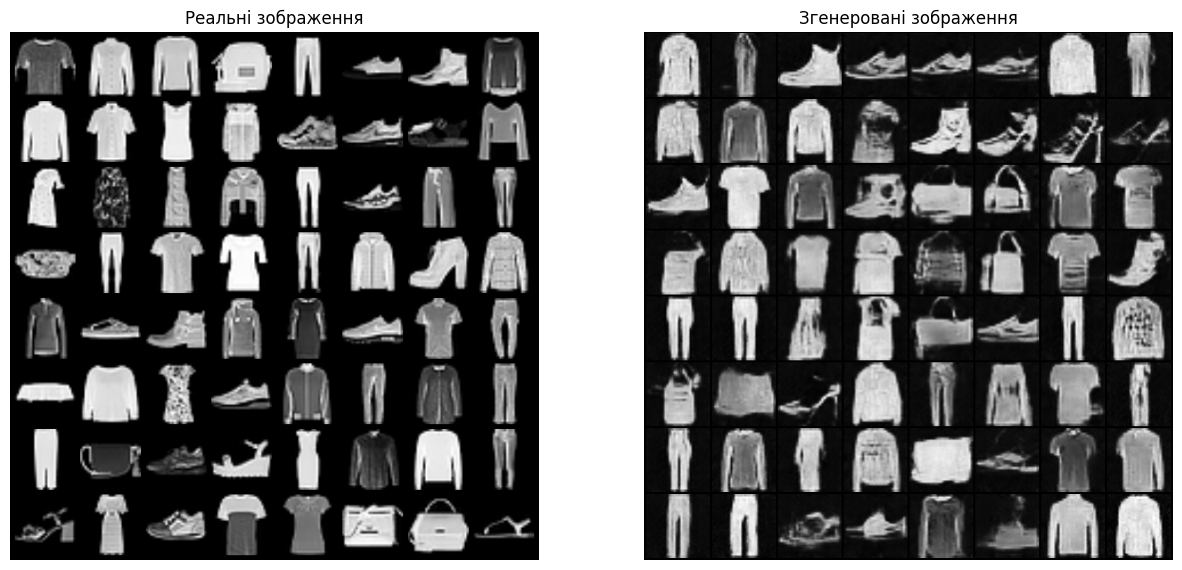

In [29]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

# Реальні
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Реальні зображення")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0][:64].to(device),
            padding=5,
            normalize=True
        ).cpu(),
        (1, 2, 0)
    )
)

# Згенеровані
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Згенеровані зображення")
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))
plt.show()

**ЗАВДАННЯ 3.** Проведіть експерименти з моделями бібліотеки Hugging Face

**а)**

In [8]:
# Підготовка даних
df = pd.read_csv('Phishing_Email.csv').dropna(subset=['Email Text', 'Email Type'])
df['label_numeric'] = df['Email Type'].map({'Phishing Email': 1, 'Safe Email': 0})

# Беремо 200 прикладів для тесту
_, test_df = train_test_split(df, test_size=200, random_state=42, stratify=df['label_numeric'])
eval_texts = test_df['Email Text'].tolist()
eval_labels = test_df['label_numeric'].tolist()


models = [
    {"name": "RoBERTa-Spam", "id": "mshenoda/roberta-spam"},
    {"name": "BERT-Spam-Tiny", "id": "mrm8488/bert-tiny-finetuned-sms-spam-detection"}
]

pipelines = {}

for m in models:
    try:
        print(f"Спроба завантажити {m['name']}...")
        pipelines[m['name']] = pipeline("text-classification", model=m['id'], device=0)
        print(f"{m['name']} завантажена успішно!")
    except Exception as e:
        print(f"Не вдалося завантажити {m['name']}. Спробуємо іншу.")

# Отримання прогнозів
def get_predictions(pipe, texts, model_name):
    print(f"\nАналіз моделлю {model_name}...")
    preds = []
    for i, text in enumerate(texts):
        try:
            # Обмеження довжини для BERT (512 токенів)
            res = pipe(text[:1000], truncation=True)[0]
            label = res['label'].upper()

            # Логіка для більшості спам-моделей:
            # LABEL_1 або 'LABEL_1' або 'SPAM' - це позитивний клас (фішинг/спам)
            if label in ['LABEL_1', 'SPAM', 'POSITIVE']:
                preds.append(1)
            else:
                preds.append(0)
        except:
            preds.append(0)

        if (i+1) % 50 == 0: print(f"Опрацьовано {i+1} текстів...")
    return preds

# Запуск та виведення звітів
for name, pipe in pipelines.items():
    preds = get_predictions(pipe, eval_texts, name)

    print(f"ЗВІТ ДЛЯ МОДЕЛІ: {name}")
    print(f"Загальна точність (Accuracy): {accuracy_score(eval_labels, preds):.4f}")
    print(classification_report(eval_labels, preds, target_names=['Safe', 'Phishing']))

Спроба завантажити RoBERTa-Spam...


Device set to use cuda:0


RoBERTa-Spam завантажена успішно!
Спроба завантажити BERT-Spam-Tiny...


Device set to use cuda:0


BERT-Spam-Tiny завантажена успішно!

Аналіз моделлю RoBERTa-Spam...
Опрацьовано 50 текстів...
Опрацьовано 100 текстів...
Опрацьовано 150 текстів...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Опрацьовано 200 текстів...
ЗВІТ ДЛЯ МОДЕЛІ: RoBERTa-Spam
Загальна точність (Accuracy): 0.9250
              precision    recall  f1-score   support

        Safe       0.95      0.93      0.94       122
    Phishing       0.89      0.92      0.91        78

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.93       200


Аналіз моделлю BERT-Spam-Tiny...
Опрацьовано 50 текстів...
Опрацьовано 100 текстів...
Опрацьовано 150 текстів...
Опрацьовано 200 текстів...
ЗВІТ ДЛЯ МОДЕЛІ: BERT-Spam-Tiny
Загальна точність (Accuracy): 0.4600
              precision    recall  f1-score   support

        Safe       0.58      0.43      0.49       122
    Phishing       0.36      0.51      0.43        78

    accuracy                           0.46       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.49      0.46      0.47       200



**с)**

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Генерація зображення...


  0%|          | 0/50 [00:00<?, ?it/s]

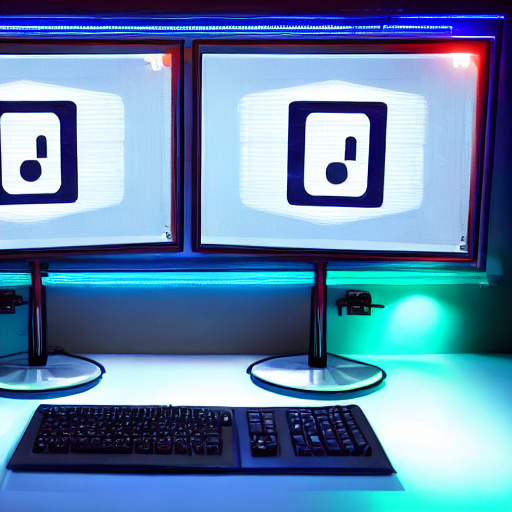

In [10]:
# Завантажуємо модель
model_id = "runwayml/stable-diffusion-v1-5"
pipe_sd = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe_sd = pipe_sd.to("cuda")

# Створюємо складний промпт (Text-to-Image)
prompt = "Cybersecurity hacker workstation in a dark room, matrix code on monitors, neon blue and red lighting, highly detailed, 8k resolution"

print("Генерація зображення...")
image = pipe_sd(prompt).images[0]

# Показ результату
image.save("cyber_hacker.png")
display(image)